# Ex 1.2: A simple parallel MapReduce framework in Python
Now we use the [*multiprocessing*](https://docs.python.org/3/library/multiprocessing.html) lib to actually do things in parallel

In [1]:
import collections
import itertools
import multiprocessing


class SimpleMapReduce:

    def __init__(self, map_func, reduce_func, num_workers=None):
        """
        map_func

          Function to map inputs to intermediate data. Takes as
          argument one input value and returns a tuple with the
          key and a value to be reduced.

        reduce_func

          Function to reduce partitioned version of intermediate
          data to final output. Takes as argument a key as
          produced by map_func and a sequence of the values
          associated with that key.

        num_workers

          The number of workers to create in the pool. Defaults
          to the number of CPUs available on the current host.
        """
        self.map_func = map_func
        self.reduce_func = reduce_func
        self.pool = multiprocessing.Pool(num_workers)

    def partition(self, mapped_values):
        """Organize the mapped values by their key.
        Returns an unsorted sequence of tuples with a key
        and a sequence of values.
        """
        partitioned_data = collections.defaultdict(list)
        for key, value in mapped_values:
            partitioned_data[key].append(value)
        return partitioned_data.items()

    def __call__(self, inputs, chunksize=1):
        """Process the inputs through the map and reduce functions
        given.

        inputs
          An iterable containing the input data to be processed.

        chunksize=1
          The portion of the input data to hand to each worker.
          This can be used to tune performance during the mapping
          phase.
        """
        map_responses = self.pool.map(
            self.map_func,
            inputs,
            chunksize=chunksize,
        )
        partitioned_data = self.partition(
            itertools.chain(*map_responses)
        )
        reduced_values = self.pool.map(
            self.reduce_func,
            partitioned_data,
        )
        return reduced_values

### A Word Count example

In [2]:
import string

# map - read file and count words
def file_to_words(filename):
    """Read a file and return a sequence of
    (word, occurences) values.
    """
    STOP_WORDS = set([
        'a', 'an', 'and', 'are', 'as', 'be', 'by', 'for', 'if',
        'in', 'is', 'it', 'of', 'or', 'py', 'rst', 'that', 'the',
        'to', 'with',
    ])
    TR = str.maketrans({
        p: ' '
        for p in string.punctuation
    })

    print('{} reading {}'.format(
        multiprocessing.current_process().name, filename))
    output = []

    with open(filename, 'rt') as f:
        for line in f:
            # Skip comment lines.
            if line.lstrip().startswith('..'):
                continue
            line = line.translate(TR)  # Strip punctuation
            for word in line.split():
                word = word.lower()
                if word.isalpha() and word not in STOP_WORDS:
                    output.append((word, 1))
    return output

# reduce
def count_words(item):
    """Convert the partitioned data for a word to a
    tuple containing the word and the number of occurences.
    """
    word, occurences = item
    return (word, sum(occurences))

In [3]:
import operator
import glob #easy file access

input_files = glob.glob('*.rst')#get all text files names 

mapper = SimpleMapReduce(file_to_words, count_words)#get mapreduce instance with custom map and reduce functions
word_counts = mapper(input_files)#call parallel mapreduce on files

word_counts.sort(key=operator.itemgetter(1))#sort results
word_counts.reverse()

print('\nTOP 20 WORDS BY FREQUENCY\n')
top20 = word_counts[:20]
longest = max(len(word) for word, count in top20)
for word, count in top20:
    print('{word:<{len}}: {count:5}'.format(
            len=longest + 1,
            word=word,
            count=count)
    )

ForkPoolWorker-3 reading text2.rst
ForkPoolWorker-4 reading text1.rst
ForkPoolWorker-1 reading text3.rst
ForkPoolWorker-2 reading text4.rst

TOP 20 WORDS BY FREQUENCY

my    :    67
i     :    60
her   :    43
he    :    41
quiz  :    33
was   :    28
quick :    28
his   :    23
fox   :    22
she   :    21
from  :    20
when  :    20
blind :    19
would :    18
so    :    18
but   :    18
have  :    18
vex   :    18
on    :    17
which :    16


## K-Means implementation
Use the simple frame work to implement K-Means

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

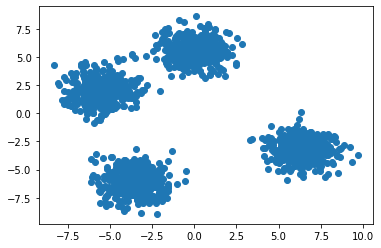

In [5]:
#generate data with K=4
X, y = make_blobs(n_samples=1500, centers=4)
plt.scatter(X[:, 0], X[:, 1])

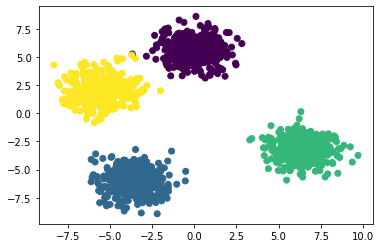

In [6]:
#K-Means ref implementation
k = KMeans(n_clusters=4)
y_pred = k.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_pred)

In [7]:
k.cluster_centers_

array([[-0.02345811,  5.61727317],
       [-3.59319396, -6.00595548],
       [ 6.36216218, -3.23388343],
       [-5.53108319,  2.02577258]])

In [8]:
np.shape(k.cluster_centers_)

(4, 2)

In [15]:
#implement map -> assign data to center 
def kMap( data, centers):
    print('{} mapping {}'.format(multiprocessing.current_process().name, data))
    output=[]
    center = 0
    min_dist = 999999999
    for c in range(np.shape(centers)[0]):
            dist = (data[0]-centers[c][0])*(data[0]-centers[c][0]) + (data[1]-centers[c][1])*(data[1]-centers[c][1])
            dist=np.sqrt(dist) 
            if dist<min_dist:
                min_dist=dist
                center = c
    output.append((center,data)) #map to tuple of center ID and data
    
    return output


In [16]:
#implement reduce -> compute new centers
def kReduce( item, centers ):
    print('{} reducing {}'.format(multiprocessing.current_process().name, item))
    center = item[1][0]
    
    for i in range(np.shape(item[1])[0]):
        center += item[1][i]
    
    center/=np.shape(item[1])[0]
    return center


In [17]:
#init centers
center = X[np.random.randint(X.shape[0], size=4), :]#get 4 random datapoints
print('init center', center)

init center [[-3.45534047 -5.69271516]
 [-6.40104313  2.47922588]
 [-3.28277197 -5.34305082]
 [ 7.2403984  -2.01403064]]


In [18]:
#use framework
from functools import partial
mapper = SimpleMapReduce(partial(kMap,centers=center), partial(kReduce, centers=center))#get mapreduce instance with custom map and reduce functions
new_center = mapper(X)#call parallel mapreduce oo data

ForkPoolWorker-9 mapping [0.16106882 6.50026164]
ForkPoolWorker-9 mapping [-6.39217888  4.2993145 ]
ForkPoolWorker-10 mapping [ 6.28191234 -3.81174189]
ForkPoolWorker-9 mapping [-5.13974057  2.44019824]
ForkPoolWorker-11 mapping [-3.48111765 -6.75437933]
ForkPoolWorker-12 mapping [-7.69770634  1.96498353]
ForkPoolWorker-12 mapping [-3.03072275 -5.09365687]
ForkPoolWorker-11 mapping [0.22716251 5.36867273]
ForkPoolWorker-10 mapping [-7.69722366  3.23811432]
ForkPoolWorker-10 mapping [-3.3372963  -5.37072572]
ForkPoolWorker-11 mapping [-6.57253165  1.93202737]
ForkPoolWorker-12 mapping [-6.49885388  4.52768879]
ForkPoolWorker-9 mapping [0.98618359 5.28393315]
ForkPoolWorker-12 mapping [0.4049482  5.53385874]
ForkPoolWorker-10 mapping [-6.54606797  2.17094542]
ForkPoolWorker-10 mapping [-5.71650558  1.16115321]
ForkPoolWorker-12 mapping [-6.76579599  0.18619985]
ForkPoolWorker-10 mapping [ 7.51132405 -4.19285386]
ForkPoolWorker-9 mapping [ 7.27871258 -4.48636138]
ForkPoolWorker-10 mapping

ForkPoolWorker-12 mapping [-0.52321308  6.44824417]
ForkPoolWorker-12 mapping [-3.12502521 -7.25704342]
ForkPoolWorker-9 mapping [-6.03525912  2.2279094 ]
ForkPoolWorker-11 mapping [ 5.91545806 -2.91236048]
ForkPoolWorker-12 mapping [-5.25795354  3.14787802]
ForkPoolWorker-9 mapping [ 5.87659369 -1.96825856]
ForkPoolWorker-12 mapping [0.65045043 3.11894767]
ForkPoolWorker-12 mapping [-2.83708545  5.05653741]
ForkPoolWorker-10 mapping [ 5.11950086 -1.43994982]
ForkPoolWorker-10 mapping [ 5.11503258 -3.07332879]
ForkPoolWorker-9 mapping [-0.38263665  5.6099012 ]
ForkPoolWorker-11 mapping [ 6.2223009  -3.38875886]
ForkPoolWorker-11 mapping [ 5.7595506  -3.67357843]
ForkPoolWorker-9 mapping [ 6.49075623 -2.38669229]
ForkPoolWorker-11 mapping [-5.16887191  3.0076863 ]
ForkPoolWorker-12 mapping [ 5.57332669 -1.42353405]
ForkPoolWorker-10 mapping [-0.94357968  6.79432215]
ForkPoolWorker-10 mapping [ 7.74447959 -2.0994671 ]
ForkPoolWorker-12 mapping [-0.31424658  5.388623  ]
ForkPoolWorker-11 

ForkPoolWorker-11 mapping [1.04100697 6.97931865]
ForkPoolWorker-12 mapping [-2.24693035  6.05533983]
ForkPoolWorker-9 mapping [ 8.43198809 -2.5203586 ]
ForkPoolWorker-10 mapping [-4.3849968 -5.8323165]
ForkPoolWorker-10 mapping [-4.88174905  2.55390376]
ForkPoolWorker-10 mapping [ 6.79426251 -3.71080301]
ForkPoolWorker-11 mapping [-2.55721658 -4.8961865 ]
ForkPoolWorker-12 mapping [-2.65170317 -4.82316933]
ForkPoolWorker-9 mapping [-2.53426276 -4.74434456]
ForkPoolWorker-11 mapping [-7.56755807  1.29902122]
ForkPoolWorker-10 mapping [ 6.5166051  -2.72220619]
ForkPoolWorker-9 mapping [-6.97869745  2.32789746]
ForkPoolWorker-9 mapping [-0.89263726  7.10558701]
ForkPoolWorker-9 mapping [-3.14486874 -6.18938338]
ForkPoolWorker-9 mapping [-0.45436282  6.03562298]
ForkPoolWorker-12 mapping [ 4.03721923 -2.16304469]
ForkPoolWorker-9 mapping [-6.25117508  1.24692407]
ForkPoolWorker-12 mapping [ 4.55959638 -2.80951883]
ForkPoolWorker-9 mapping [-5.40121858  2.93855881]
ForkPoolWorker-10 mappin

ForkPoolWorker-12 mapping [-6.19713954  1.52405946]
ForkPoolWorker-11 mapping [-0.46051903  6.16764057]
ForkPoolWorker-10 mapping [ 6.68553138 -3.24283493]
ForkPoolWorker-12 mapping [-6.94407301  1.84228517]
ForkPoolWorker-11 mapping [1.52614411 5.25533623]
ForkPoolWorker-12 mapping [0.63163645 6.91788083]
ForkPoolWorker-9 mapping [-4.88539609 -3.84329578]
ForkPoolWorker-11 mapping [-2.37823804 -5.6076163 ]
ForkPoolWorker-11 mapping [-0.08740356  5.82098021]
ForkPoolWorker-10 mapping [-4.89208739  2.44533815]
ForkPoolWorker-9 mapping [-5.31870563 -7.88392013]
ForkPoolWorker-12 mapping [ 7.50031359 -2.9834549 ]
ForkPoolWorker-9 mapping [-0.54785878  5.1010369 ]
ForkPoolWorker-10 mapping [-5.16710463 -4.80737262]
ForkPoolWorker-12 mapping [-3.57792557 -5.44009272]
ForkPoolWorker-9 mapping [-1.16786566  6.69238305]
ForkPoolWorker-10 mapping [ 5.39178384 -2.62087582]
ForkPoolWorker-12 mapping [-1.33842069  4.9405595 ]
ForkPoolWorker-12 mapping [-5.14170319  2.23242853]
ForkPoolWorker-11 ma

ForkPoolWorker-10 mapping [-5.28541375 -0.04501543]
ForkPoolWorker-9 mapping [ 6.49714051 -2.54283364]
ForkPoolWorker-11 mapping [-3.17029839 -5.96845352]
ForkPoolWorker-10 mapping [-5.11622805  0.40367528]
ForkPoolWorker-10 mapping [ 6.96233934 -2.0656764 ]
ForkPoolWorker-10 mapping [ 5.55883931 -2.31377671]
ForkPoolWorker-10 mapping [-5.8163573   4.01259012]
ForkPoolWorker-12 mapping [-3.95647847 -6.76776752]
ForkPoolWorker-10 mapping [ 7.13566244 -3.91014422]
ForkPoolWorker-11 mapping [-0.85202582  5.00843319]
ForkPoolWorker-9 mapping [-3.96598617 -5.23539017]
ForkPoolWorker-11 mapping [-3.84295423 -6.96732568]
ForkPoolWorker-11 mapping [ 7.88304512 -4.38587899]
ForkPoolWorker-10 mapping [-4.09047187 -7.00361565]
ForkPoolWorker-12 mapping [-7.18920794  1.9672036 ]
ForkPoolWorker-9 mapping [-1.61970847  4.23651322]
ForkPoolWorker-10 mapping [-6.99334357  3.53799605]
ForkPoolWorker-11 mapping [-4.78892499 -5.07975443]
ForkPoolWorker-10 mapping [ 8.23861672 -2.29060809]
ForkPoolWorker-

ForkPoolWorker-12 mapping [-5.53804049  1.325184  ]
ForkPoolWorker-9 mapping [-7.55397928  0.95046309]
ForkPoolWorker-11 mapping [0.2338671  5.89460746]
ForkPoolWorker-10 mapping [-2.48915057 -7.34295317]
ForkPoolWorker-9 mapping [-1.12945387  5.29109477]
ForkPoolWorker-11 mapping [-0.87281413  5.15630318]
ForkPoolWorker-10 mapping [-6.11316025 -4.09500514]
ForkPoolWorker-9 mapping [ 4.46148751 -2.27804566]
ForkPoolWorker-12 mapping [ 5.02977069 -4.29455695]
ForkPoolWorker-10 mapping [ 5.91420875 -3.45254558]
ForkPoolWorker-9 mapping [-3.14391075 -7.5867676 ]
ForkPoolWorker-11 mapping [0.64027574 5.70918291]
ForkPoolWorker-11 mapping [-5.02895571  2.91105031]
ForkPoolWorker-9 mapping [-4.62051463 -7.25992629]
ForkPoolWorker-12 mapping [-4.29548665 -7.77101669]
ForkPoolWorker-9 mapping [ 6.53971739 -2.7032306 ]
ForkPoolWorker-12 mapping [-1.75578349  6.13872929]
ForkPoolWorker-9 mapping [0.03385113 5.66959368]
ForkPoolWorker-12 mapping [1.22947971 7.36240812]
ForkPoolWorker-9 mapping [ 

ForkPoolWorker-10 mapping [-4.23837884 -5.23750555]
ForkPoolWorker-9 mapping [-0.07438385  4.52384038]
ForkPoolWorker-10 mapping [-5.41277671  2.13194435]
ForkPoolWorker-9 mapping [-2.56237656 -5.45781845]
ForkPoolWorker-12 mapping [-3.71271618  5.16554511]
ForkPoolWorker-11 mapping [-2.10172693 -6.01286748]
ForkPoolWorker-9 mapping [2.44866031 4.43664762]
ForkPoolWorker-12 mapping [-3.38012095 -5.85554815]
ForkPoolWorker-11 mapping [-0.58955716  6.09749806]
ForkPoolWorker-9 mapping [-0.1500431   5.83301827]
ForkPoolWorker-12 mapping [-6.39792915  0.35487986]
ForkPoolWorker-9 mapping [-3.46522255 -5.03264654]
ForkPoolWorker-12 mapping [0.28879503 4.99256169]
ForkPoolWorker-9 mapping [-3.94311935  1.6848117 ]
ForkPoolWorker-11 mapping [0.63911853 5.92406865]
ForkPoolWorker-12 mapping [ 6.71160126 -2.86739962]
ForkPoolWorker-9 mapping [-3.37054244 -6.37461869]
ForkPoolWorker-11 mapping [-4.82154658  2.23318838]
ForkPoolWorker-10 mapping [-5.15487657  2.48327316]
ForkPoolWorker-9 mapping 

ForkPoolWorker-12 mapping [-2.93907788 -5.92891449]
ForkPoolWorker-10 mapping [ 5.98868735 -2.92904574]
ForkPoolWorker-11 mapping [-4.9526264   2.29281648]
ForkPoolWorker-10 mapping [-0.50630207 -5.15186656]
ForkPoolWorker-12 mapping [ 7.05333599 -2.53553738]
ForkPoolWorker-10 mapping [1.42312436 5.21053732]
ForkPoolWorker-10 mapping [-4.13330691 -4.16408736]
ForkPoolWorker-9 mapping [ 6.8888943  -2.89931927]
ForkPoolWorker-9 mapping [-3.22481186 -5.98138881]
ForkPoolWorker-10 mapping [ 6.66114163 -3.07150739]
ForkPoolWorker-10 mapping [-2.66672884 -6.73774741]
ForkPoolWorker-9 mapping [-0.71541529  3.32148348]
ForkPoolWorker-10 mapping [-3.42215556 -7.61393009]
ForkPoolWorker-12 mapping [ 4.73755886 -2.47148048]
ForkPoolWorker-10 mapping [-0.60161365  4.65214443]
ForkPoolWorker-12 mapping [ 7.48885771 -3.198369  ]
ForkPoolWorker-10 mapping [-0.67905315  6.59356114]
ForkPoolWorker-10 mapping [ 6.15797142 -3.17726499]
ForkPoolWorker-12 mapping [-5.23316935  2.22771661]
ForkPoolWorker-10

ForkPoolWorker-9 mapping [-0.58794719  6.16985807]
ForkPoolWorker-10 mapping [-5.77132027  2.17326114]
ForkPoolWorker-11 mapping [ 5.67734869 -1.70803197]
ForkPoolWorker-11 mapping [-5.60218287  3.04230412]
ForkPoolWorker-11 mapping [-4.78810818  1.36682268]
ForkPoolWorker-11 mapping [-1.93559148 -7.76676977]
ForkPoolWorker-11 mapping [-6.49463477  2.87017624]
ForkPoolWorker-10 mapping [-0.10507648  4.93998212]
ForkPoolWorker-11 mapping [-1.30495962  5.5851082 ]
ForkPoolWorker-11 mapping [ 6.20191495 -3.13442268]
ForkPoolWorker-12 mapping [-3.42653123 -6.04627238]
ForkPoolWorker-9 mapping [ 4.39775355 -4.92353291]
ForkPoolWorker-11 mapping [ 6.22424815 -0.49140778]
ForkPoolWorker-11 mapping [-6.18995354  3.65393624]
ForkPoolWorker-11 mapping [ 6.42625173 -5.66730811]
ForkPoolWorker-9 mapping [-0.07998533  6.74294592]
ForkPoolWorker-12 mapping [ 6.22104447 -3.97919283]
ForkPoolWorker-11 mapping [-1.73227551 -6.75045132]
ForkPoolWorker-9 mapping [ 7.40742854 -3.60188235]
ForkPoolWorker-1

ForkPoolWorker-9 mapping [-0.02490677  6.70129496]
ForkPoolWorker-10 mapping [-5.03358474 -5.95104312]
ForkPoolWorker-12 mapping [-1.8643213  -5.81285057]
ForkPoolWorker-11 mapping [ 5.80306308 -2.75935997]
ForkPoolWorker-10 mapping [ 7.00494133 -2.80007757]
ForkPoolWorker-12 mapping [-3.44786966 -5.79215815]
ForkPoolWorker-10 mapping [ 6.42212944 -5.27866829]
ForkPoolWorker-11 mapping [0.63774176 5.42782545]
ForkPoolWorker-12 mapping [0.9859025  5.40770975]
ForkPoolWorker-10 mapping [-4.52633674 -6.8617475 ]
ForkPoolWorker-10 mapping [ 6.57951102 -3.02992954]
ForkPoolWorker-12 mapping [0.08684016 5.25631359]
ForkPoolWorker-12 mapping [-4.09140333 -6.49828328]
ForkPoolWorker-10 mapping [-5.17025279  2.42510903]
ForkPoolWorker-9 mapping [-6.38034884  3.10176642]
ForkPoolWorker-12 mapping [-3.41924763 -6.81895539]
ForkPoolWorker-10 mapping [-4.82430661  1.29838836]
ForkPoolWorker-9 mapping [-1.53607654  5.85729928]
ForkPoolWorker-11 mapping [0.59134994 7.56262959]
ForkPoolWorker-10 mappi

ForkPoolWorker-9 reducing (0, [array([-3.48111765, -6.75437933]), array([-4.74204475, -6.59351893]), array([-3.66193772, -6.97788896]), array([-3.96081246, -6.73253184]), array([-4.02237406, -7.35262447]), array([-5.78343248, -5.73396384]), array([-2.78981977, -6.08442233]), array([-3.29606935, -6.51693516]), array([-2.15182699, -7.20913482]), array([-5.20670183, -8.21082879]), array([-5.9845503 , -5.44658208]), array([-4.5289386 , -5.97254912]), array([-4.14492637, -6.31722016]), array([-3.95538211, -5.83173966]), array([-4.75642237, -5.59291502]), array([-4.06118931, -7.12104992]), array([-5.04689706, -6.53419587]), array([-4.08694965, -5.90993501]), array([-2.26104381, -7.70672339]), array([-3.55886361, -7.2614871 ]), array([-3.40132875, -7.26840497]), array([-5.75721994, -5.61454017]), array([-2.47607534, -7.30790651]), array([-2.97596061, -7.64993088]), array([-5.64316243, -6.35250081]), array([-2.66091765, -7.38347596]), array([-3.39517645, -6.00417812]), array([-3.12502521, -7.2

ForkPoolWorker-10 reducing (1, [array([0.16106882, 6.50026164]), array([-7.69770634,  1.96498353]), array([-6.39217888,  4.2993145 ]), array([-5.13974057,  2.44019824]), array([-7.69722366,  3.23811432]), array([0.98618359, 5.28393315]), array([0.22716251, 5.36867273]), array([-6.49885388,  4.52768879]), array([-6.57253165,  1.93202737]), array([0.4049482 , 5.53385874]), array([-6.54606797,  2.17094542]), array([-6.76579599,  0.18619985]), array([-5.02058138,  2.78696182]), array([-5.71650558,  1.16115321]), array([-0.20164016,  5.46257667]), array([-1.88396237,  6.27728165]), array([-5.6302746 ,  2.84437174]), array([-1.08483111,  5.97671976]), array([-5.11967368,  1.98431663]), array([-6.05883576,  1.60956948]), array([-0.03583052,  5.6069457 ]), array([-4.14597974,  1.34035889]), array([-0.11415682,  5.01713989]), array([-1.63455567,  4.53118668]), array([-5.95702122,  3.35473067]), array([0.77373761, 5.72409582]), array([0.18831409, 5.65066216]), array([-5.35205611,  2.07912448]), 

In [13]:
new_center #new centers 

[array([-0.01325196,  5.63562518]),
 array([ 6.37891395, -3.24404807]),
 array([-3.60247694, -6.02396716]),
 array([-5.54663136,  2.039584  ])]

In [19]:
#compare to Scikit-Learn resusult - Note: order of centers is random
k.cluster_centers_

array([[-0.02345811,  5.61727317],
       [-3.59319396, -6.00595548],
       [ 6.36216218, -3.23388343],
       [-5.53108319,  2.02577258]])

In [14]:
#now run int in a loop to get K-Means iterations ...
